In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import vapeplot 
from scipy import interp
import scipy.stats
%matplotlib inline

#### Goal
--------------------

The goal of this project is to make a classifier that predicts the final rankings for bakers.
The idea is to make a model for each episode and to use data from previous episodes in the model.
Therefore, a classifier for episode 1 will likely be bad at predicting the final outcome, but a classifier for episode 5 might accurately predict who will be in the top 3 and who might be eliminated in the next episode



In [2]:
from datetime import datetime
def timestamp(): return datetime.today().strftime('%Y%m%d')

from sklearn.preprocessing import QuantileTransformer
def quantile_scale(df,feats):
    qua = df
    scaler = QuantileTransformer(
        n_quantiles=10,
        random_state=42,
        ignore_implicit_zeros=True, #sparse matrix
    )
    # fit the scaler
    scaler.fit(qua[feats])
    # transform values
    qua[feats] = scaler.transform(qua[feats])
    return qua
def tiered(classes):
    trans = []
    for x in classes:
        if x==1: c=0
        if x==2: c=1
        if x>=3 and x<=4: c=2
        if x>=5 and x<=7: c=3
        if x>=8: c=4
        trans.append(c)
    return trans

In [3]:
gbbo = pd.read_csv("../RESULTS/gbbo.features.s10.e2.20190909.tsv".format(),sep="\t")
gbbo.head()

,season,baker,episode,place,tech_mean,tech,mean_star,star,mean_good,good,mean_bad,bad
0,10,Alice,1,0,5.0,5,0.0,0,0.0,0,0.0,0
1,10,Alice,2,0,3.0,1,0.5,1,0.5,1,0.0,0
2,10,Amelia,1,0,4.0,4,0.0,0,0.0,0,0.0,0
3,10,Amelia,2,0,6.5,9,0.0,0,0.0,0,0.5,1
4,10,Dan,1,13,9.0,9,0.0,0,0.0,0,1.0,1


In [4]:
gbbo = pd.read_csv("../RESULTS/gbbo.features.s10.e2.20190909.tsv".format(),sep="\t")
feats = ['tech_mean','tech','mean_star','star','mean_good','good','mean_bad','bad']
max_epi = max(gbbo['episode'])
gbbo = gbbo.loc[gbbo['episode']==max_epi]
gbbo = quantile_scale(gbbo,feats)
gbbo.head()

/Users/tacitus/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:2088: UserWarning: 'ignore_implicit_zeros' takes effect only with sparse matrix. This parameter has no effect.
  warnings.warn("'ignore_implicit_zeros' takes effect only with"


,season,baker,episode,place,tech_mean,tech,mean_star,star,mean_good,good,mean_bad,bad
1,10,Alice,2,0,1.000000e-07,8.333333e-02,9.999999e-01,9.999999e-01,9.999999e-01,9.999999e-01,1.000000e-07,1.000000e-07
3,10,Amelia,2,0,5.555556e-01,7.500000e-01,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07,8.888889e-01,9.999999e-01
5,10,Dan,2,13,2.500000e-01,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07,8.888889e-01,1.000000e-07
7,10,David,2,0,4.166667e-01,1.666667e-01,1.000000e-07,1.000000e-07,9.999999e-01,9.999999e-01,1.000000e-07,1.000000e-07
9,10,Helena,2,0,9.999999e-01,9.999999e-01,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07


In [5]:
tech = pd.read_csv("../RESULTS/gbbo.features.20190909.tsv",sep='\t')
tech = tech.loc[tech['episode']==max_epi]
qua = quantile_scale(tech,feats)
qua['place']=tiered(qua['place'])
X, y = np.matrix(qua[feats]), np.array(qua['place'])

/Users/tacitus/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:2088: UserWarning: 'ignore_implicit_zeros' takes effect only with sparse matrix. This parameter has no effect.
  warnings.warn("'ignore_implicit_zeros' takes effect only with"


In [6]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.activations import relu
input_shape = len(feats)
output_shape = len(set(tech['place']))
def create_model( nl1=1, nl2=1,  nl3=1, 
                 nn1=1000, nn2=500, nn3 = 200, lr=0.01, decay=0., l1=0.01, l2=0.01,
                act = 'relu', dropout=0,input_shape=input_shape,output_shape=output_shape):    
    '''This is a model generating function so that we can search over neural net 
    parameters and architecture
    https://www.kaggle.com/arrogantlymodest/randomised-cv-search-over-keras-neural-network
    '''
    opt = keras.optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999,  decay=decay)
    reg = keras.regularizers.l1_l2(l1=l1, l2=l2)
    model = Sequential()
    first=True  
    for i in range(nl1):
        if first:
            model.add(Dense(nn1, input_dim=input_shape, activation=act, kernel_regularizer=reg))
            first=False
        else: 
            model.add(Dense(nn1, activation=act, kernel_regularizer=reg))
        if dropout!=0:
            model.add(Dropout(dropout))    
    for i in range(nl2):
        if first:
            model.add(Dense(nn2, input_dim=input_shape, activation=act, kernel_regularizer=reg))
            first=False
        else: 
            model.add(Dense(nn2, activation=act, kernel_regularizer=reg))
        if dropout!=0:
            model.add(Dropout(dropout))    
    for i in range(nl3):
        if first:
            model.add(Dense(nn3, input_dim=input_shape, activation=act, kernel_regularizer=reg))
            first=False
        else: 
            model.add(Dense(nn3, activation=act, kernel_regularizer=reg))
        if dropout!=0:
            model.add(Dropout(dropout))       
    model.add(Dense(output_shape, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'],)
    return model
##################################
l1 = 0.0001
l2 = 0.0001
lr = 0.0001
nl1 = 1
nl2 = 1
nl3 = 1
nn1 = 800
nn2 = 800
nn3 = 300

dropout = 0.1
decay = 1e-09
act='relu'
n_dims = len(feats)
n_classes = len(set(tech['place']))

nn = create_model( nl1=nl1, nl2=nl2,  nl3=nl3, 
                     nn1=nn1, nn2=nn2, nn3 = nn3, 
                     lr=lr, decay=decay, l1=l1, l2=l2,
                     act = act, dropout=dropout,
                     input_shape=n_dims,
                     output_shape=n_classes)

BATCH,EPOCHS = 12, 25
####
X, y = np.matrix(qua[feats]), np.array(qua['place'])
gbbo = pd.read_csv("../RESULTS/gbbo.features.s10.e2.20190909.tsv".format(),sep="\t")
feats = ['tech_mean','tech','mean_star','star','mean_good','good','mean_bad','bad']
max_epi = max(gbbo['episode'])
gbbo = gbbo.loc[gbbo['episode']==max_epi]
gbbo = quantile_scale(gbbo,feats)
test = np.matrix(gbbo[feats])

tech = pd.read_csv("../RESULTS/gbbo.features.20190909.tsv",sep='\t')
tech = tech.loc[tech['episode']==max_epi]
qua = quantile_scale(tech,feats)
qua['place']=tiered(qua['place'])
nn.fit(X,y,validation_split=0., batch_size=BATCH, epochs=EPOCHS,verbose=0)

preds = nn.predict_classes(test)
probs = nn.predict_proba(test)
gbbo['preds']=preds
# probability baker is a finalist
top = probs[:,0]
# probability baker is a finalist or a runner-up
top3 = probs[:,0]+probs[:,1]
# bottom tier (8th and below)
bot = probs[:,-1]
gbbo['bottom']=np.round(bot*100,decimals=2)
gbbo['finalist']=np.round(top*100,decimals=2) 
gbbo['top3'] = np.round(top3*100,decimals=2)
gbbo.to_csv("../RESULTS/gbbo.techinical.s10.e2.keras.preditions.txt",sep="\t",index=False)
sub = ['baker','preds','finalist','top3','bottom']
gbbo = gbbo[sub].sort_values(by=['finalist'],ascending=False)
print(gbbo)

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/Users/tacitus/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:2088: UserWarning: 'ignore_implicit_zeros' takes effect only with sparse matrix. This parameter has no effect.
  warnings.warn("'ignore_implicit_zeros' takes effect only with"
/Users/tacitus/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:2088: UserWarning: 'ignore_implicit_zeros' takes effect only with sparse matrix. This parameter has no effect.
  warnings.warn("'ignore_implicit_zeros' takes effect only with"


Instructions for updating:
Use tf.cast instead.
       baker  preds   finalist       top3     bottom
1      Alice      1  33.950001  85.769997   2.580000
23     Rosie      1  20.580000  49.759998   8.090000
15   Michael      1  20.320000  61.070000  14.220000
7      David      1  19.540001  65.110001  12.210000
25     Steph      2  12.670000  37.220001   8.540000
11     Henry      3   9.020000  23.790001  17.230000
19      Phil      4   8.360000  22.360001  28.719999
21     Priya      4   4.320000  14.830000  31.940001
17  Michelle      3   4.060000  14.300000  29.209999
9     Helena      3   2.010000   9.400000  31.730000
5        Dan      4   1.920000   5.250000  84.120003
3     Amelia      4   1.300000   4.750000  57.619999
13     Jamie      4   0.420000   1.980000  76.309998


/Users/tacitus/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())
/Users/tacitus/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())
/Users/tacitus/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


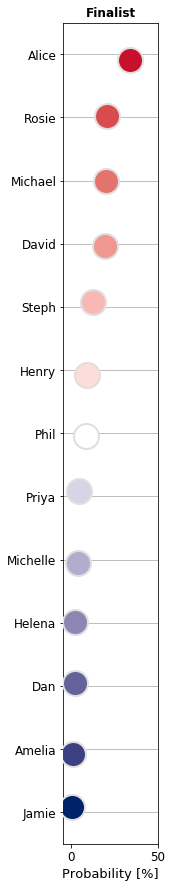

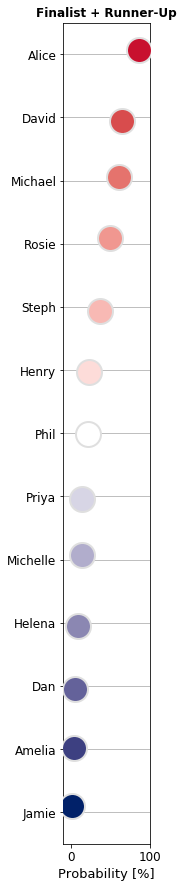

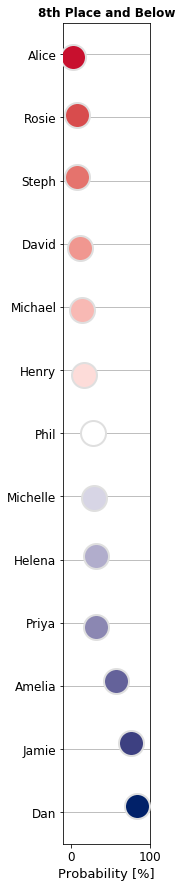

In [7]:
def plot_probs(df,x,xlab,ofh,xmin=-9,xmax=100):
    col=['#012169', '#3d4081', '#64629a', '#8b87b2', '#b1adcc', '#d7d5e5', '#ffffff', '#fddcd9', '#f8b9b4', '#f09790', '#e5736d', '#d84c4d', '#c8102e']
    colrs=reversed(col)

    vapeplot.font_size(12)
    f, ax = plt.subplots(1,1,figsize=(2.5,5*2.5))
    sns.stripplot(
        y='baker',
        x=x,
        data=df,
        linewidth=2, 
        edgecolor="#dfdfdf",
        size=25,
        ax=ax,
        palette=colrs
    )
    ax.set_ylabel('')
    ax.yaxis.grid(True)
    ax.set_xlim(xmin,xmax)
    ax.set_title(xlab,fontsize=12,weight='bold')
    ax.set_xlabel('Probability [%]',fontsize=13)
    f.tight_layout()
    f.savefig(ofh,dpi=150)
    f.show()

plot_probs(gbbo,'finalist','Finalist','../FIGURES/s10.e2.finalist.png',-4.5,50)   
plot_probs(gbbo.sort_values(ascending=False,by=['top3']),'top3','Finalist + Runner-Up','../FIGURES/s10.e2.top3.png')
plot_probs(gbbo.sort_values(ascending=True,by=['bottom']),'bottom','8th Place and Below','../FIGURES/s10.e2.bottom.png')

In [8]:
gbbo[sub].sort_values(by=['bottom'],ascending=False)

,baker,preds,finalist,top3,bottom
5,Dan,4,1.920000,5.250000,84.120003
13,Jamie,4,0.420000,1.980000,76.309998
3,Amelia,4,1.300000,4.750000,57.619999
21,Priya,4,4.320000,14.830000,31.940001
9,Helena,3,2.010000,9.400000,31.730000
17,Michelle,3,4.060000,14.300000,29.209999
19,Phil,4,8.360000,22.360001,28.719999
11,Henry,3,9.020000,23.790001,17.230000
15,Michael,1,20.320000,61.070000,14.220000
7,David,1,19.540001,65.110001,12.210000


In [9]:
gbbo[sub].sort_values(by=['top3'],ascending=False)


,baker,preds,finalist,top3,bottom
1,Alice,1,33.950001,85.769997,2.580000
7,David,1,19.540001,65.110001,12.210000
15,Michael,1,20.320000,61.070000,14.220000
23,Rosie,1,20.580000,49.759998,8.090000
25,Steph,2,12.670000,37.220001,8.540000
11,Henry,3,9.020000,23.790001,17.230000
19,Phil,4,8.360000,22.360001,28.719999
21,Priya,4,4.320000,14.830000,31.940001
17,Michelle,3,4.060000,14.300000,29.209999
9,Helena,3,2.010000,9.400000,31.730000


/Users/tacitus/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:2088: UserWarning: 'ignore_implicit_zeros' takes effect only with sparse matrix. This parameter has no effect.
  warnings.warn("'ignore_implicit_zeros' takes effect only with"
/Users/tacitus/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:2088: UserWarning: 'ignore_implicit_zeros' takes effect only with sparse matrix. This parameter has no effect.
  warnings.warn("'ignore_implicit_zeros' takes effect only with"
/Users/tacitus/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())
/Users/tacitus/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())
/Users/t

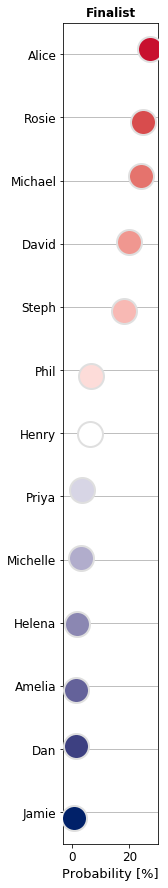

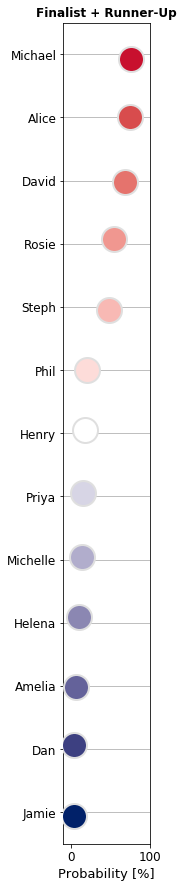

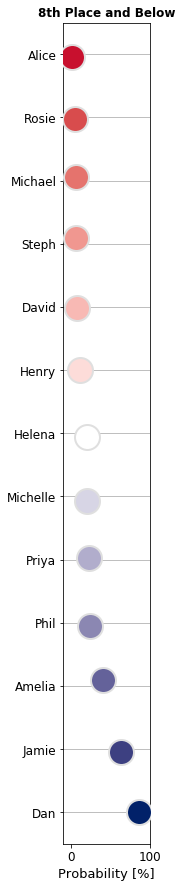

In [10]:
tech = pd.read_csv("../RESULTS/gbbo.features.20190909.tsv",sep='\t')
tech = tech.loc[(tech['episode']==2) | (tech['episode']==3)]
qua = quantile_scale(tech,feats)
qua['place']=tiered(qua['place'])
X, y = np.matrix(qua[feats]), np.array(qua['place'])
nn = create_model( nl1=nl1, nl2=nl2,  nl3=nl3, 
                     nn1=nn1, nn2=nn2, nn3 = nn3, 
                     lr=lr, decay=decay, l1=l1, l2=l2,
                     act = act, dropout=dropout,
                     input_shape=n_dims,
                     output_shape=n_classes)
nn.fit(X,y,validation_split=0., batch_size=BATCH, epochs=EPOCHS,verbose=0)
gbbo = pd.read_csv("../RESULTS/gbbo.features.s10.e2.20190909.tsv".format(),sep="\t")
feats = ['tech_mean','tech','mean_star','star','mean_good','good','mean_bad','bad']
max_epi = max(gbbo['episode'])
gbbo = gbbo.loc[gbbo['episode']==max_epi]
gbbo = quantile_scale(gbbo,feats)
test = np.matrix(gbbo[feats])
preds = nn.predict_classes(test)
probs = nn.predict_proba(test)
gbbo['preds']=preds
# probability baker is a finalist
top = probs[:,0]
top3 = probs[:,0]+probs[:,1]
bot = probs[:,-1]
gbbo['bottom']=np.round(bot*100,decimals=2)
gbbo['finalist']=np.round(top*100,decimals=2) 
gbbo['top3'] = np.round(top3*100,decimals=2)
#gbbo.to_csv("../RESULTS/gbbo.techinical.s10.e2.keras.preditions.txt",sep="\t",index=False)
sub = ['baker','preds','finalist','top3','bottom']
gbbo = gbbo[sub].sort_values(by=['finalist'],ascending=False)

plot_probs(gbbo,'finalist','Finalist','../FIGURES/s10.e2-3.finalist.png',-3,30)   
plot_probs(gbbo.sort_values(ascending=False,by=['top3']),'top3','Finalist + Runner-Up','../FIGURES/s10.e2-3.top3.png')
plot_probs(gbbo.sort_values(ascending=True,by=['bottom']),'bottom','8th Place and Below','../FIGURES/s10.e2-3.bottom.png')



In [11]:
gbbo[sub].sort_values(by=['bottom'],ascending=False)

,baker,preds,finalist,top3,bottom
5,Dan,4,1.360000,4.140000,86.220001
13,Jamie,4,0.580000,3.740000,63.369999
3,Amelia,4,1.500000,6.420000,41.439999
19,Phil,3,6.490000,20.090000,24.430000
21,Priya,3,3.450000,15.210000,23.770000
17,Michelle,3,3.160000,14.390000,20.660000
9,Helena,3,1.620000,10.970000,20.049999
11,Henry,3,6.380000,18.190001,12.410000
7,David,1,20.040001,68.650002,8.700000
25,Steph,2,18.090000,47.880001,7.030000
